In [26]:
import matplotlib as mpl

font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os

mpl.rcParams['axes.formatter.useoffset'] = False

In [27]:
import utils.load_grid as lg

In [28]:
pgrid_dir = "data/article_data/mnras_proteus_agni/hd63433d_v6"
# pgrid_dir = "data/article_data/mnras_proteus_agni/ltt3780b_v5"
cases = lg.get_cases(pgrid_dir)

In [29]:
# Collect netcdf files
stts = lg.get_statuses(pgrid_dir)

print(" ")

# Configuration variables
cvars = lg.load_cvars(cases)

print(" ")

# Helpfiles
helps, hvars = lg.load_helpfiles(cases)

print("Done")

Configs:   0%|          | 0/22 [00:00<?, ?it/s]

Configs: 100%|██████████| 22/22 [00:00<00:00, 574.02it/s]


Helpfiles: 100%|██████████| 22/22 [00:00<00:00, 83.55it/s]


Done


In [30]:
def _pie(ax, x, y, s, ratios, colors, tris=50):

    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x_tmp  = [0] + np.cos(np.linspace(previous, this, tris)).tolist() + [0]
        y_tmp  = [0] + np.sin(np.linspace(previous, this, tris)).tolist() + [0]
        xy = np.column_stack([x_tmp, y_tmp])
        previous = this
        markers.append({'marker':xy, 's':(np.abs(xy).max())**2*s, 'facecolor':color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter([x], [y], **marker)

    return ax

In [31]:
def make_pies(x,x_lbl, y,y_lbl, control, 
                plot_casenums=False,plot_controls=False, plot_psurf=True, plot_legend=True, dark_theme=False, 
                logx=False, logy=False, title="", r_ref=3.0, time_idx=-1, 
                ytick=[], yticklbl=[], xtick=[], xticklbl=[], figsize=(6,5), xlim=[], ylim=[],
                outpath="output/recent_pies.pdf"):
    # Make plot
    x_plt = np.array([], dtype=float) # x variable
    y_plt = np.array([], dtype=float) # y variable
    c_plt = np.array([], dtype=int)   # case number
    g_plt = np.array([], dtype=bool)  # case finished with success? (good)
    g_plt = np.array([], dtype=bool)  # case finished with failure? (bad)
    for i in range(len(x)):
        skip_this = False
        for k in control.keys():
            if k in cvars.keys():
                if not np.isclose(cvars[k][i],control[k]):
                    skip_this = True
                    break
        if skip_this:
            continue
        x_plt = np.append(x_plt, x[i])
        y_plt = np.append(y_plt, y[i])
        c_plt = np.append(c_plt, i)
        g_plt = np.append(g_plt, bool( 10 <= stts[i] <= 19))
    if len(x_plt) == 0:
        print("WARNING: No data left after applying control variables!")
        return

    b_plt = np.invert(g_plt)

    fig,ax = plt.subplots(1,1, figsize=figsize)

    present = np.full(len(lg.volatile_species), False)
    for j,v in enumerate(lg.volatile_species):
        for i in range(len(x_plt)):
            r = lg.access_hvars(hvars,v+"_vmr",-1)[c_plt[i]]
            if r > 1.0e-30:
                present[j] = True

    # Make the pies
    p_ref = np.amax(lg.access_hvars(hvars,"P_surf",-1))
    print("Reference pressure = %g bar"%p_ref)
    for i in range(len(x_plt)):
        ratios = []
        colors = []
        for j,v in enumerate(lg.volatile_species):
            if not present[j]:
                continue
            ratios.append(lg.access_hvars(hvars,v+"_vmr",time_idx)[c_plt[i]])
            colors.append(lg.volatile_colors[v])
        tot = np.sum(ratios)
        if tot < 1.0 - 1e-5:
            raise Exception("Mixing ratios do not sum to unity (sum=%.10f)"%tot)

        ax.scatter([x_plt[i]], [y_plt[i]], alpha=0.0)

        # plot pie chart
        ax_sub= inset_axes(ax, width=r_ref, height=r_ref, loc="center",
                    bbox_to_anchor=(x_plt[i], y_plt[i]),
                    bbox_transform=ax.transData,
                    borderpad=0)
        wedges,texts= ax_sub.pie(ratios, colors=colors)

        # move pie chart weges onto base plot
        # https://stackoverflow.com/a/56935492
        for p in wedges:
            p.remove()
            ax.add_patch(p)
            p.set_zorder(2)
            p.set_clip_on(True)

        if plot_psurf:
            p_surf_log = np.log10(lg.access_hvars(hvars,"P_surf",time_idx)[c_plt[i]])
            ax.text(x_plt[i],y_plt[i],
                        "%.1f"%p_surf_log,
                        color="white",
                        horizontalalignment="center", verticalalignment="center",
                        fontsize=10.9)

    # Legend
    if plot_legend:
        patches = []
        for j,v in enumerate(lg.volatile_species):
            if present[j]:
                patches.append(mpatches.Patch(color=lg.volatile_colors[v], label=lg.volatile_pretty[v]))
        leg = ax.legend(handles=patches,loc='upper center', bbox_to_anchor=(0.5, -0.53), ncol=4, 
                        title="",fancybox=True, framealpha=0.5, labelspacing=0.2)
        if dark_theme:
            leg.get_frame().set_alpha(0)

    if plot_casenums:
        for i in range(len(x_plt)):
            ax.text(x_plt[i],y_plt[i],c_plt[i],fontsize=7, color='magenta', horizontalalignment='center', verticalalignment='center')

    if plot_controls:
        control_str = "Control variables:\n"
        for k in control.keys():
            control_str += "  %s=%g\n" % (k,control[k])
        control_str = control_str[:-1]
        axt = ax.text(0.05, 0.95, control_str,
                horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=10)
        axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    ax.set_xlabel(x_lbl)
    ax.set_ylabel(y_lbl)
    if logy:
        ax.set_yscale("log")
    if logx:
        ax.set_xscale("log")

    if len(xtick) > 0:
        ax.set_xticks(xtick)
    if len(xticklbl) > 0:
        ax.set_xticklabels(xticklbl)

    if len(ytick) > 0:
        ax.set_yticks(ytick)
    if len(yticklbl) > 0:
        ax.set_yticklabels(yticklbl)

    if len(xlim) == 2:
        ax.set_xlim(xlim)

    if len(ylim) == 2:
        ax.set_ylim(ylim)

    if len(title)>0:
        ax.set_title(title, fontsize=12)

    fig.savefig(outpath, bbox_inches='tight', transparent=True)
    plt.show()

Reference pressure = 2579.19 bar


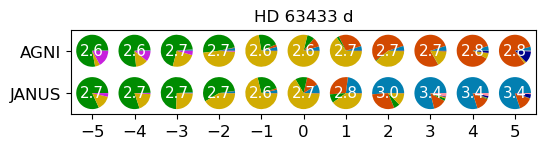

data/article_data/mnras_proteus_agni/hd63433d_v6


In [34]:
# Y-variables
y = cvars["atmosphere_model"]
y_lbl = ""
logy=False
ytick = [0,1]
yticklbl = ["JANUS","AGNI"]
ylim=[-0.5,1.5]

# X-variables
x = cvars["fO2_shift_IW"]
x_lbl = ""
# x_lbl = "log$_{10}$ (fO$_{2}$ / IW)"
logx=False
xtick = np.unique(x)
xticklbl = []
xlim=[]


# Control variables
# control = {"mean_distance":0.1, "hydrogen_earth_oceans":1.0}
control = {}

# Plotting parameters
plot_controls = False
plot_casenums = False
plot_psurf =    True
# title         = r"$[H]$ = %d ocean%s"%(control["hydrogen_earth_oceans"], "s" if (control["hydrogen_earth_oceans"]!=1) else "" )
title = "HD 63433 d"
r_ref         = 0.4
figsize = (6,1.1)
outpath       = "output/recent_pies.pdf"
plot_legend   = False
time_idx      = -1
dark          = False

if dark:
    COLOR = 'white'
else:
    COLOR = 'black'

mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR

make_pies(x,x_lbl, y,y_lbl, control, logx=logx, logy=logy, time_idx=time_idx, dark_theme=dark, plot_psurf=plot_psurf, 
            ytick=ytick, yticklbl=yticklbl, xtick=xtick, xticklbl=xticklbl, figsize=figsize, ylim=ylim, xlim=xlim,
            plot_casenums=plot_casenums, plot_controls=plot_controls, plot_legend=plot_legend, title=title, r_ref=r_ref, outpath=outpath)

print(pgrid_dir)